In [1]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, ConstantKernel, Matern, Exponentiation
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from common import detpep10exp, load_detpep10exp_dataset, plot_init, plot_3d

## Analyze different kernels

In [28]:
# Plot setup
plot_init()

# Load dataset
X, y = load_detpep10exp_dataset(n_samples=10, sample_range=(0.01, 1))
print(X.shape)
print(y.shape)

# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=43
)

# Dict to save results
scores = {}

(1000, 3)
(1000,)


### Constant kernel

In [45]:
# Define constant value
cv = 1.
# Initialize kernel
kernel = ConstantKernel(cv)
kernel = Exponentiation(kernel, 2)
# Train
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=30)
gpr.fit(X_train, y_train)
# Evaluate
score = gpr.score(X_test, y_test)
print('R2 for constant value {}: {}'.format(cv, score))
scores['constant + exponentiation'] = score

/Users/frederikrogge/miniforge3/envs/compsci-project/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


R2 for constant value 1.0: -0.35470174330987425


### Radial basis function (RBF) kernel

In [32]:
# Define length scale
ls = 1.
# Initialize kernel
kernel = RBF(length_scale=ls)
# Train
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=30)
gpr.fit(X_train, y_train)
# Evaluate
score = gpr.score(X_test, y_test)
print('R2 for length scale {}: {}'.format(ls, score))
scores['rbf'] = score

R2 for length scale 1.0: 0.9999966918327482


### Matern kernel

In [33]:
# Define length scale and nu
ls = 1.
nu = 1.5
# Initialize kernel
kernel = Matern(length_scale=ls, nu=nu)
# Train
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=30)
gpr.fit(X_train, y_train)
# Evaluate
score = gpr.score(X_test, y_test)
print('R2 for length scale {} and nu {}: {}'.format(ls, nu, score))
scores['matern'] = score

R2 for length scale 1.0 and nu 1.5: 0.999823868572345


### Dot product

In [39]:
# Define sigma
sigma = 1
# Initialize kernel
kernel = DotProduct(sigma_0=sigma)
# Train
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=30)
gpr.fit(X_train, y_train)
# Evaluate
score = gpr.score(X_test, y_test)
print('R2 for sigma {}: {}'.format(sigma, score))
scores['dot product'] = score

/Users/frederikrogge/miniforge3/envs/compsci-project/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


R2 for sigma 1: 0.7225136128491906


### Dot product + exponentiation

In [40]:
# Define sigma
sigma = 1
# Initialize kernel
kernel = DotProduct(sigma_0=sigma)
kernel = Exponentiation(kernel, 2)
# Train
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=40)
gpr.fit(X_train, y_train)
# Evaluate
score = gpr.score(X_test, y_test)
print('R2 for sigma {}: {}'.format(sigma, score))
scores['dot product + exponentiation'] = score

/Users/frederikrogge/miniforge3/envs/compsci-project/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


R2 for sigma 1: 0.9819082361265389


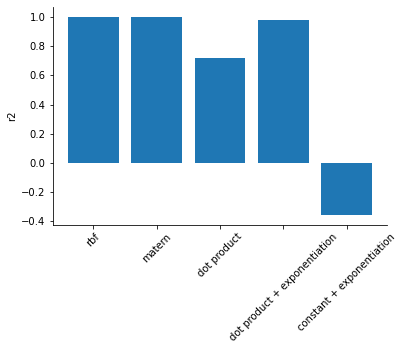

In [48]:
fig, ax = plt.subplots()
ax.bar(list(scores.keys()), list(scores.values()))
ax.set_ylabel('r2')
ax.tick_params(axis='x', rotation=45)
plt.show()

### Uncertainty

Here we use a rbf kernel and measure the level of uncertainty for all datapoints. It shows that the uncertainty gets higher closer to the limits of the sampling range.

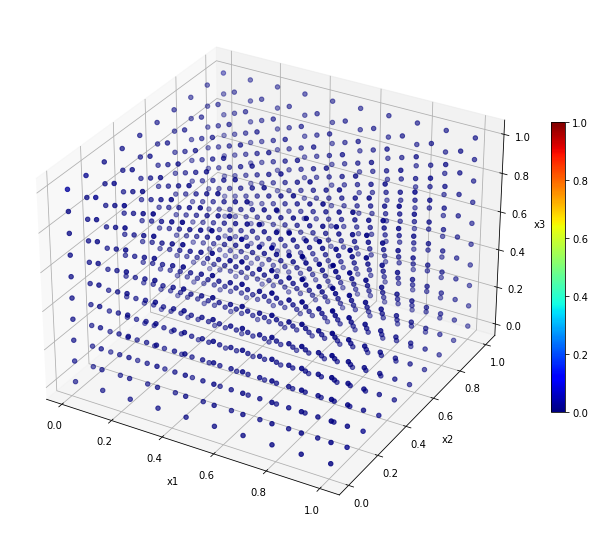

In [5]:
# Define length scale
ls = 1.
# Initialize kernel
kernel = RBF(length_scale=ls)
# Train
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)
gpr.fit(X_train, y_train)
X, y = load_detpep10exp_dataset(n_samples=10, sample_range=(0.01, 1))
y_pred, y_std = gpr.predict(X, return_std=True)
# Plot
plot_3d(X, y_std, vmin=0, vmax=1)

Next, we look at the uncertainty if we train only on a limit range and test outside our training range. This will also reveal something about the extrapolation capabilities of our model.

For this purpose, we 'train' our model only on datapoints for x3 < 0.5. Then, we report the R^2 for both sub-regions (x3 >= 0.5 and x3 < 0.5). In addition to that, we plot the uncertainty levels over the entire range.

R2 score on trained region is 1.00
R2 score on untrained region is -1.80


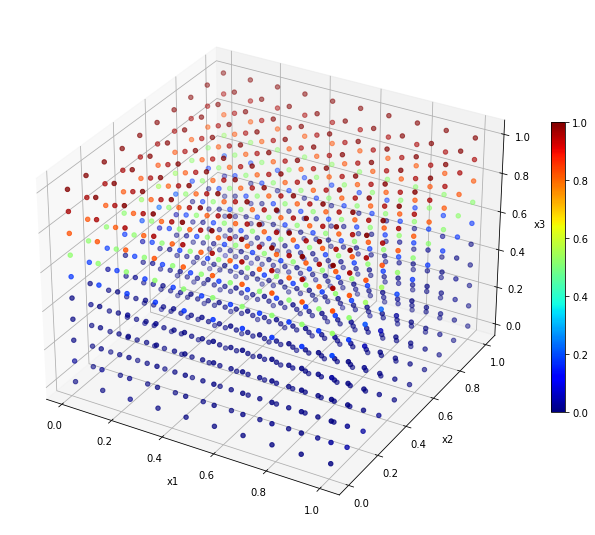

In [6]:
# Define length scale
ls = 1.
# Initialize kernel
kernel = RBF(length_scale=ls)
# Train
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)
gpr.fit(X_train[X_train[:, 2]<0.5, :], y_train[X_train[:, 2]<0.5])

# Score on trained sub-region
trained_score = gpr.score(X_test[X_test[:, 2]<0.5, : ], y_test[X_test[:, 2]<0.5])
print('R2 score on trained region is {:.2f}'.format(trained_score))
# Score on untrained sub-region
untrained_score = gpr.score(X_test[X_test[:, 2]>=0.5, : ], y_test[X_test[:, 2]>=0.5])
print('R2 score on untrained region is {:.2f}'.format(untrained_score))

y_pred, y_std = gpr.predict(X, return_std=True)
# Plot
plot_3d(X, y_std, vmin=0, vmax=1)

/Users/frederikrogge/miniforge3/envs/compsci-project/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


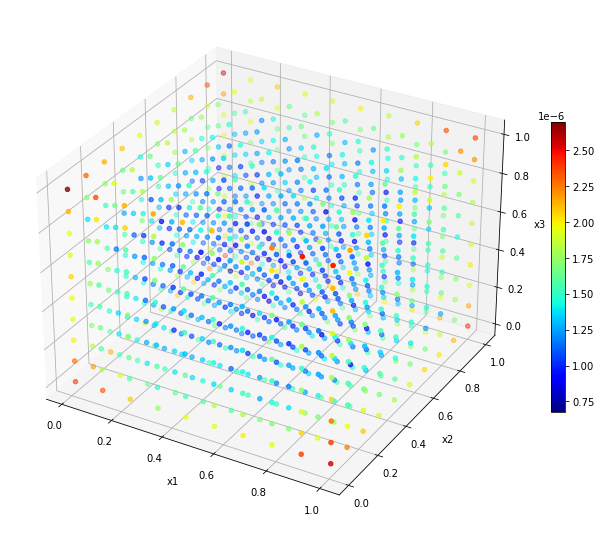

In [11]:
# Define sigma
sigma = 1
# Initialize kernel
kernel = DotProduct(sigma_0=sigma)
kernel = Exponentiation(kernel, 2)
# Train
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=30)
gpr.fit(X_train, y_train)
X, y = load_detpep10exp_dataset(n_samples=10, sample_range=(0.01, 1))
y_pred, y_std = gpr.predict(X, return_std=True)
# Plot
plot_3d(X, y_std)

R2 score on trained region is 0.97
R2 score on untrained region is 0.22


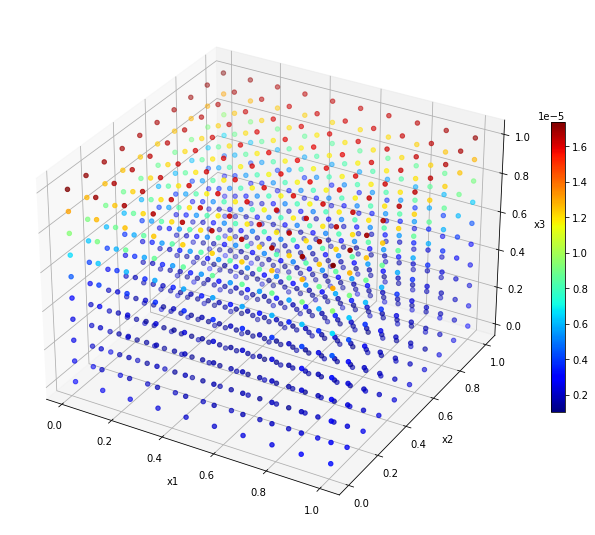

In [9]:
# Define sigma
sigma = 1.0
# Initialize kernel
kernel = DotProduct(sigma_0=sigma)
kernel = Exponentiation(kernel, 2)
# Train
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50)
gpr.fit(X_train[X_train[:, 2]<0.5, :], y_train[X_train[:, 2]<0.5])

# Score on trained sub-region
trained_score = gpr.score(X_test[X_test[:, 2]<0.5, : ], y_test[X_test[:, 2]<0.5])
print('R2 score on trained region is {:.2f}'.format(trained_score))
# Score on untrained sub-region
untrained_score = gpr.score(X_test[X_test[:, 2]>=0.5, : ], y_test[X_test[:, 2]>=0.5])
print('R2 score on untrained region is {:.2f}'.format(untrained_score))
# Plot
y_pred, y_std = gpr.predict(X, return_std=True)
plot_3d(X, y_std)

### Adding noise to the data

Here, we will noise to all of the datapoints (train and test).

R2 on noisy dataset using rbf kernel: 0.79
R2 on noisy dataset using rbf + white kernel: 0.55


/Users/frederikrogge/miniforge3/envs/compsci-project/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


R2 on noisy dataset using exponentiation + dot product kernel: 0.93
R2 on noisy dataset using exponentiation + dot product kernel + white kernel: 0.81


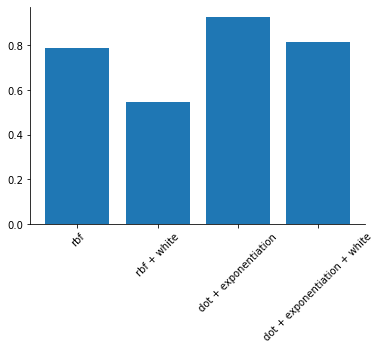

In [49]:
noise_scores = {}

# Load dataset
X, y = load_detpep10exp_dataset(n_samples=10, sample_range=(0.01, 1))

# Add noise
y = y + np.random.normal(loc=0., scale=2, size=y.shape)

# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=43
)

# ------------------------------ RBF kernel ------------------------------
# Define length scale and noise level
ls = 1.
nl = 1.
# Train
gpr = GaussianProcessRegressor(kernel=RBF(length_scale=ls), n_restarts_optimizer=30)
gpr.fit(X_train, y_train)
# Evaluate
score = gpr.score(X_test, y_test)
print('R2 on noisy dataset using rbf kernel: {:.2f}'.format(score))
noise_scores['rbf'] = score

# --------------------------- RBF + white kernel ---------------------------
# Train
gpr = GaussianProcessRegressor(kernel=RBF(length_scale=ls) + WhiteKernel(noise_level=nl), n_restarts_optimizer=30)
gpr.fit(X_train, y_train)
# Evaluate
score = gpr.score(X_test, y_test)
print('R2 on noisy dataset using rbf + white kernel: {:.2f}'.format(score))
noise_scores['rbf + white'] = score

# --------------------------- Dot + exponentiation ---------------------------
# Train
gpr = GaussianProcessRegressor(kernel=Exponentiation(DotProduct(sigma_0=1), 2), n_restarts_optimizer=30)
gpr.fit(X_train, y_train)
# Evaluate
score = gpr.score(X_test, y_test)
print('R2 on noisy dataset using exponentiation + dot product kernel: {:.2f}'.format(score))
noise_scores['dot + exponentiation'] = score

# ------------------------ Dot + exponentiation + white ------------------------
# Train
gpr = GaussianProcessRegressor(kernel=Exponentiation(DotProduct(sigma_0=1), 2) + WhiteKernel(noise_level=nl), n_restarts_optimizer=30)
gpr.fit(X_train, y_train)
# Evaluate
score = gpr.score(X_test, y_test)
print('R2 on noisy dataset using exponentiation + dot product kernel + white kernel: {:.2f}'.format(score))
noise_scores['dot + exponentiation + white'] = score

# Bar plot
fig, ax = plt.subplots()
ax.bar(list(noise_scores.keys()), list(noise_scores.values()))
ax.tick_params(axis='x', rotation=45)
plt.show()

Here, we will noise only to our test samples and measure how well we can predict on the true underlying function data without noise.

R2 on noisy training samples using rbf kernel: 0.84
R2 on noisy training samples using rbf + white kernel: 0.58
R2 on noisy training samples using exponentiation + dot product kernel: 0.98


/Users/frederikrogge/miniforge3/envs/compsci-project/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


R2 on noisy training samples using exponentiation + dot product kernel + white kernel: 0.86


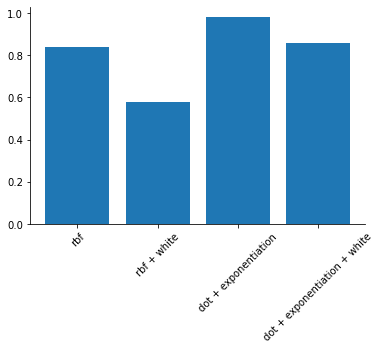

In [51]:
noise_scores = {}

# Load dataset
X, y = load_detpep10exp_dataset(n_samples=10, sample_range=(0.01, 1))

# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=43
)

# Add noise
y_train = y_train + np.random.normal(loc=0., scale=2, size=y_train.shape)

# ------------------------------ RBF kernel ------------------------------
# Define length scale and noise level
ls = 1.
nl = 1.
# Train
gpr = GaussianProcessRegressor(kernel=RBF(length_scale=ls), n_restarts_optimizer=30)
gpr.fit(X_train, y_train)
# Evaluate
score = gpr.score(X_test, y_test)
print('R2 on noisy training samples using rbf kernel: {:.2f}'.format(score))
noise_scores['rbf'] = score

# --------------------------- RBF + white kernel ---------------------------
# Train
gpr = GaussianProcessRegressor(kernel=RBF(length_scale=ls) + WhiteKernel(noise_level=nl), n_restarts_optimizer=30)
gpr.fit(X_train, y_train)
# Evaluate
score = gpr.score(X_test, y_test)
print('R2 on noisy training samples using rbf + white kernel: {:.2f}'.format(score))
noise_scores['rbf + white'] = score

# --------------------------- Dot + exponentiation ---------------------------
# Train
gpr = GaussianProcessRegressor(kernel=Exponentiation(DotProduct(sigma_0=1), 2), n_restarts_optimizer=30)
gpr.fit(X_train, y_train)
# Evaluate
score = gpr.score(X_test, y_test)
print('R2 on noisy training samples using exponentiation + dot product kernel: {:.2f}'.format(score))
noise_scores['dot + exponentiation'] = score

# ------------------------ Dot + exponentiation + white ------------------------
# Train
gpr = GaussianProcessRegressor(kernel=Exponentiation(DotProduct(sigma_0=1), 2) + WhiteKernel(noise_level=nl), n_restarts_optimizer=30)
gpr.fit(X_train, y_train)
# Evaluate
score = gpr.score(X_test, y_test)
print('R2 on noisy training samples using exponentiation + dot product kernel + white kernel: {:.2f}'.format(score))
noise_scores['dot + exponentiation + white'] = score

# Bar plot
fig, ax = plt.subplots()
ax.bar(list(noise_scores.keys()), list(noise_scores.values()))
ax.tick_params(axis='x', rotation=45)
plt.show()